## Spatial analysis with ridership data
 
Hi, this is Shinah. I'm going to show how I applied spaticial correlation to our team's research. Audrey used job point data of LA in the other notebook and here, I used Seoul ridership data, which is a point data. Each point is a location of a subway station in Seoul and it has ridership data in it.   
(CAVEAT: An error called 'cannot convert float NaN to integer' appeared whenever I tried mapping on contextily basemap. When I plot the map without the basemap code, there appears no issue. Searched through Stackoverflow but couldn't solve it. Wonder how to solve this..)

Import library

In [1]:
#The usuals
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx

# new for data viz
import seaborn as sns

# to explore point patterns
from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


Import a file to use

In [2]:
#abbrevated 'seoul ridership' to 'sr'
sr = gpd.read_file('data/Seoul_rail_ridership2.json')

Check the shape

In [3]:
sr.head()

,line,stn_name,st_nm,ridership,geometry
0,1호선,시청(1)역,시청(1)역,852766,POINT (198018.000 451601.000)
1,1호선,종각(1)역,종각(1)역,1309829,POINT (198343.000 452018.000)
2,1호선,동대문(1)역,동대문(1)역,504353,POINT (201032.000 452179.000)
3,1호선,동묘앞(1)역,동묘앞(1)역,423253,POINT (201444.000 452367.000)
4,1호선,신설동(1)역,신설동(1)역,613813,POINT (202246.000 452552.000)


### Heat map

Plot a basic heat map

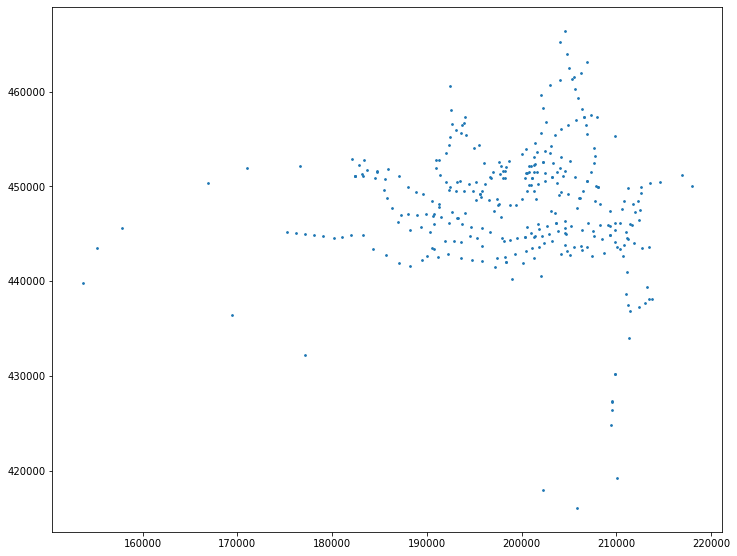

In [4]:
sr.plot(figsize=(12,12),
             markersize=3)

We can see that the subway stations delineates the boundary of Seoul. Also, it is obvious that the points are densely populated within Seoul boundary. The area where points are sparesly populated is outside of Seoul. (This shapefile does not inclde most of the stations located outskirts of Seoul, so there are only few stations in the northeast part of the map.) 

### Interactive Map

Tried making interactive map just to practice the code. This part does not directly relate to the research direction.

Make a list that have lines in it. I'm going to make a interactive map that drop downs the line names.

In [5]:
lines = sr.line.value_counts().index.tolist()
lines

['7호선',
 '5호선',
 '2호선',
 '6호선',
 '3호선',
 '9호선',
 '4호선',
 '분당선',
 '8호선',
 '9호선2~3단계',
 '공항철도 1호선',
 '1호선',
 '수인선',
 '경원선']

Import that interact library

In [6]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

Make a fuction that will be used to interact with a user.

interactive(children=(Dropdown(description='lines', options=('7호선', '5호선', '2호선', '6호선', '3호선', '9호선', '4호선', …

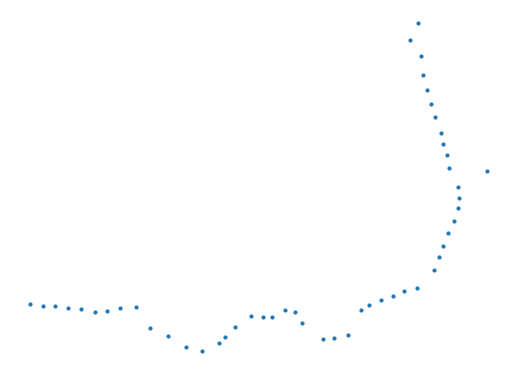

In [7]:
# to make this function interactive
@interact

# function argument will become interactive
def _by(lines=lines):
    # table
    display(sr[sr.line == lines].head()) 

    # map
    ax = sr[sr.line == lines].plot(figsize=(9,9), markersize=10)
    
    # axis
    ax.axis('off')

    # basemap
    ctx.add_basemap(ax,
                    crs='epsg:4326', # surprise! You can change the crs here!
                    source=ctx.providers.CartoDB.Positron)

I can choose the staions to see by lines by using this interactive map.   
'Cannot convert float NaN to integer' error appeared as I mentioned in the introduction of this notebook. If I eliminate the ctx.basemap code line that calls the basemap, the error disappears. 

### Join plot with Seaborn (KDE analysis)

Seaborn needs an x and y column extracting it from the geometry field

In [8]:
sr['x'] = sr.geometry.x
sr['y'] = sr.geometry.y

In [9]:
sr.head()

,line,stn_name,st_nm,ridership,geometry,x,y
0,1호선,시청(1)역,시청(1)역,852766,POINT (198018.000 451601.000),198018.0,451601.0
1,1호선,종각(1)역,종각(1)역,1309829,POINT (198343.000 452018.000),198343.0,452018.0
2,1호선,동대문(1)역,동대문(1)역,504353,POINT (201032.000 452179.000),201032.0,452179.0
3,1호선,동묘앞(1)역,동묘앞(1)역,423253,POINT (201444.000 452367.000),201444.0,452367.0
4,1호선,신설동(1)역,신설동(1)역,613813,POINT (202246.000 452552.000),202246.0,452552.0


(Just copied the limits here from the previous weeks' notebook just in case)   
ax.set_ylim(4501300.15,  4537149.12)   
ax.set_xlim(14113715.08, 14161258.91)  

The below two cells are attempts to solve the 'Cannot convert float NaN to integer' error because it appears again in this section also..

In [10]:
sr.loc[sr['x'].notnull(), 'x'] = sr.loc[sr['x'].notnull(), 'x'].apply(int)
sr.loc[sr['y'].notnull(), 'y'] = sr.loc[sr['y'].notnull(), 'y'].apply(int)

In [11]:
sr['ridership'] = sr['ridership'].dropna()

https://stackoverflow.com/questions/64448611/how-can-i-solve-the-issue-valueerror-cannot-convert-float-nan-to-integer-in-phttps://seaborn.pydata.org/generated/seaborn.kdeplot.html   
https://www.python-graph-gallery.com/73-control-bandwidth-of-seaborn-density-plot   

Anyways, plotting the joint plot to see the KDE result. Here, a thing to notice is I weighted 'ridership' column when calculating the kernel density to see where people used the subway most. This is because calculating the density only taking account the point location of station just executes a density that means the place where there are many stations.

/opt/conda/lib/python3.8/site-packages/contextily/tile.py:579: RuntimeWarning: invalid value encountered in subtract
  lon_length = np.subtract(*lon_range)
/opt/conda/lib/python3.8/site-packages/contextily/tile.py:584: RuntimeWarning: divide by zero encountered in double_scalars
  zoom_lat = np.ceil(np.log2(360 * 2.0 / lat_length))


ValueError: cannot convert float NaN to integer

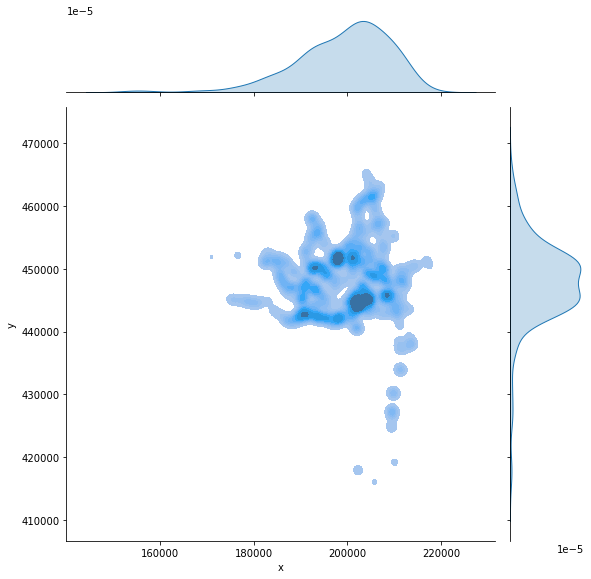

In [12]:
g = sns.jointplot(data = sr,
              x='x', 
              y='y', 
              kind='kde',
              height=8, # make the map bigger
              bw_method=0.1,
              weights= sr['ridership'],
              fill=True
              #xlim=(4501300.15,  4537149.12),
              #ylim=(14113715.08, 14161258.91)
                 )
#sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
# add basemap
ctx.add_basemap(g.ax_joint,
                crs='epsg:4326')

# Clean axes
g.ax_joint.set_axis_off()

This shows that Gangnam province has the highest KDE when weighted the density by ridership. There are about 6 regions that has the darkest blue in Seoul, but among the 6 areas, gangnam has the largest area that has darkest blue. This means that at Gangnam, not only one station has a high ridership, but also a few stations around Gangnam also has relatively high railway ridership.

--This is the end of the notebook. This was created by Shinah. Audrey will show the job density analysis in another notebook.--